In [1]:
# !pip install sentence-transformers
from sentence_transformers import SentenceTransformer
# !pip install faiss-cpu
# !pip install rake-nltk
import torch
from sentence_transformers import SentenceTransformer
import numpy as np 
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
from sklearn.metrics import jaccard_score
from sklearn.feature_extraction.text import CountVectorizer
import faiss
from rake_nltk import Rake
import nltk
import spacy
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
# !pip install spacy
# ! python -m spacy download en_core_web_md
import spacy
from spacy.lang.en.examples import sentences 
nlp = spacy.load("en_core_web_md")
from sklearn.metrics import ndcg_score, dcg_score

In [2]:
coco_annotation_file_path = "C:\\Users\\Yuanxuan\\Desktop\\CS\\CS 260\\annotations\\captions_train2014.json"
coco_caps = COCO(annotation_file=coco_annotation_file_path)
ann_ids = coco_caps.getAnnIds()
#print(f"Number of annotations: {len(ann_ids)}")

all = {}
for i in ann_ids:
#   #coco_caps.showAnns(anns)
    cap = coco_caps.loadAnns(i)[0].get('caption')
    id = coco_caps.loadAnns(i)[0].get('image_id')
    if id not in all:
         all[id] = cap
    else:
         all[id] += cap

all1 = {}
for i in ann_ids:
    #coco_caps.showAnns(anns)
    cap = coco_caps.loadAnns(i)[0].get('caption')
    id = coco_caps.loadAnns(i)[0].get('image_id')
   
    all1[id] = cap

loading annotations into memory...
Done (t=0.41s)
creating index...
index created!


In [3]:
model = SentenceTransformer('bert-base-nli-mean-tokens', device = 'cuda')
beddings = np.load("C:\\Users\\Yuanxuan\\Desktop\\CS\\CS 260\\annotations\\embeddings.npy")

In [4]:
d = beddings.shape[1]
index = faiss.IndexFlatL2(d)    
index.is_trained

True

In [5]:
index.add(beddings)

In [6]:
# Load validation captions
coco_annotation_file_path_v = "C:\\Users\\Yuanxuan\\Desktop\\CS\\CS 260\\annotations\\captions_val2014.json"
coco_caps_v = COCO(annotation_file=coco_annotation_file_path_v)
ann_ids_v = coco_caps_v.getAnnIds()
#print(f"Number of annotations: {len(ann_ids)}")

all_v = {}
for i in ann_ids_v:
#   #coco_caps_v.showAnns(anns)
    cap_v = coco_caps_v.loadAnns(i)[0].get('caption')
    id_v = coco_caps_v.loadAnns(i)[0].get('image_id')
    if id_v not in all:
         all[id_v] = cap_v
    else:
         all[id_v] += cap_v

all1_v = {}
for i in ann_ids_v:
    #coco_caps_v.showAnns(anns)
    cap_v = coco_caps_v.loadAnns(i)[0].get('caption')
    id_v = coco_caps_v.loadAnns(i)[0].get('image_id')
   
    all1_v[id_v] = cap_v

loading annotations into memory...
Done (t=0.46s)
creating index...
index created!


In [7]:
emb1 = []
res_v = list(all1_v.keys())
for j in range(len(res_v)):
    sentences = [all1_v[res_v[j]]]
    embedding1 = [nlp(sentence).vector for sentence in sentences]
    emb1.append(embedding1)
# print(emb[1][0])

In [8]:
emb2 = []
res = list(all.keys())
for j in range(len(res)):
    sentences = [all[res[j]]]
    embedding2 = [nlp(sentence).vector for sentence in sentences]
    emb2.append(embedding2)

In [12]:
from math import sqrt, pow, exp
def squared_sum(x):
  """ return 3 rounded square rooted value """
 
  return round(sqrt(sum([a*a for a in x])),3)

def cos_similarity(x,y):
  """ return cosine similarity between two lists """
 
  numerator = sum(a*b for a,b in zip(x,y))
  denominator = squared_sum(x)*squared_sum(y)
  return round(numerator/float(denominator),3)

In [36]:
res_v = list(all1_v.keys())
thislist = []
relevant_count_list = []
for j in range(len(res_v[0:100])):

    input = all1_v[res_v[j]]
    xq = model.encode([input])
    D, I = index.search(xq, k1)
#     res = list(all1.keys())

    # Top k of searcching (All True (True_postive and True Negative))
    
    k = 100

    thislist1 = []
    relevant_count = 0
    for i in I[0][0:k]:
#         sentences = [input, all1[res[i]]]
#         embeddings = [nlp(sentence).vector for sentence in sentences]
        s = cos_similarity(emb1[j][0], emb2[i][0])
        thislist1.append(s)
        # print(s)

        if (s >= 0.7):
            relevant_count += 1
    relevant_count_list.append(relevant_count)
    thislist.append(thislist1)

In [37]:
import numpy as np
from sklearn.metrics import ndcg_score

In [38]:
# Calculate NDCG Score
ndcg_score_list = []
for i in range(len(thislist)):

    ideal_order = thislist[i]
    ideal_order.sort(reverse=True)
    
    scores = np.asarray([ideal_order])
    
    true_relevance = np.asarray([thislist[i]])

    ndcg = ndcg_score(true_relevance, scores)
  
    ndcg_score_list.append(ndcg)

# print(ndcg_score_list)
print(Average(ndcg_score_list))

1.0000000000000002


In [39]:
# Precision at k: relevent item / k
precision_k_list = []
for j in range(len(res_v[0:100])):
    precision_k = relevant_count_list[j]/k
    precision_k_list.append(precision_k)
    # print("Precision at k: " + str(precision_k))
print(Average(precision_k_list))

0.9512


In [40]:
# Find all False (false_postive and false_negative)
relevant_count1_list = []

for j in range(len(res_v[0:100])):
    input = all1_v[res_v[j]]
    xq = model.encode([input])
    D, I = index.search(xq, k1)
    res = list(all1.keys())
    
    relevant_count1 = 0
    for i in I[0][(k):1000]:
        s = cos_similarity(emb1[j][0], emb2[i][0])

        if (s >= 0.7):
            relevant_count1 += 1
        relevant_count1_list.append(relevant_count1)

In [41]:
# Prevision, Recall, and F1 Score
# TP = True Positive，TN = True Negative，FP = False Positive，FN = False Negative
p_list = []
r_list = []
f1_list =[]
for i in range(len(res_v[0:100])):
    TP = relevant_count_list[i]
    TN = k-relevant_count_list[i]
    FP = relevant_count1_list[i]
    FN = k1-k-relevant_count1_list[i]
#     print(TP)
#     print(TN)
#     print(FP)
#     print(FN)
    p = TP / (TP + FP)
    r = TP / (TP + FN)
    f1 = 2 * p * r / (p + r)
    p_list.append(p)
    r_list.append(r)
    f1_list.append(f1)
    # print("Precision score: " + str(p))
    # print("Recall score: " + str(r))
    # print("F1 score: " + str(f1))
print("Precision score: " + str(Average(p_list)))
print("Recall score:: " + str(Average(r_list)))
print("F1 score: " + str(Average(f1_list)))

Precision score: 0.6699671013540341
Recall score:: 0.001149756975174108
F1 score: 0.0022954028311679086


# plot in different criterion

In [53]:
"""In different relevant criterion """
k1 = 82783
relevant_score = [0.5, 0.6, 0.7, 0.8, 0.9]
relevant_count_final = []
final_list = []
for m in relevant_score:
    res_v = list(all1_v.keys())
    thislist = []
    relevant_count_list = []
    for j in range(len(res_v[0:100])):

        input = all1_v[res_v[j]]
        xq = model.encode([input])
        D, I = index.search(xq, k1)
    #     res = list(all1.keys())

        # Top k of searcching (All True (True_postive and True Negative))
        k = 100

        thislist1 = []
        relevant_count = 0
        for i in I[0][0:k]:
    #         sentences = [input, all1[res[i]]]
    #         embeddings = [nlp(sentence).vector for sentence in sentences]
            s = cos_similarity(emb1[j][0], emb2[i][0])
            thislist1.append(s)
            # print(s)

            if (s >= m):
                relevant_count += 1
        relevant_count_list.append(relevant_count)
        thislist.append(thislist1)
    relevant_count_final.append(relevant_count_list)
    final_list.append(thislist)

In [54]:
def Average(lst):
    return sum(lst) / len(lst)

In [55]:
ave_relevant_count_final = []
for i in range(len(relevant_count_final)):
    average = Average(relevant_count_final[i])
    ave_relevant_count_final.append(average)

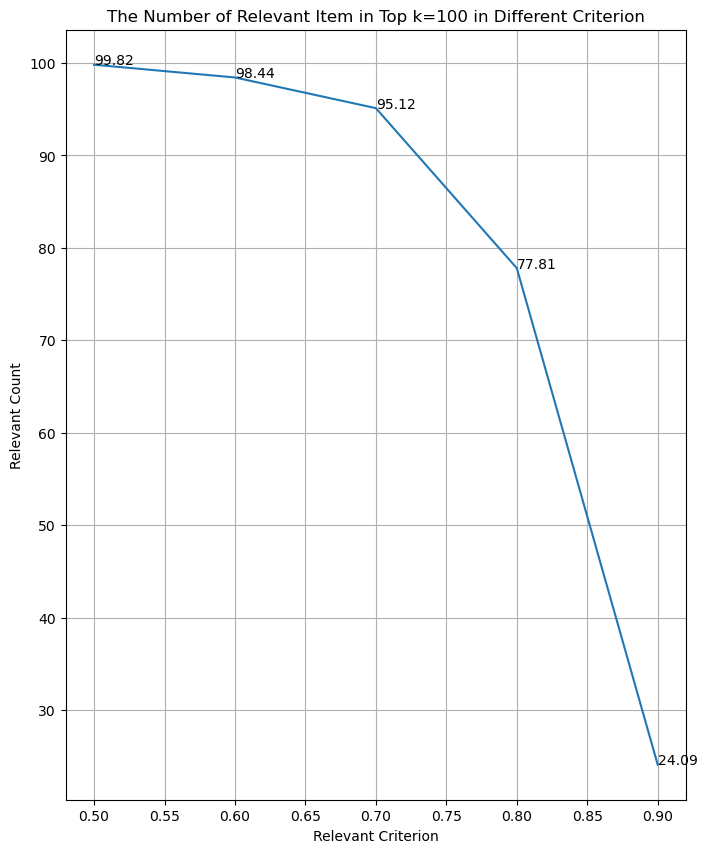

In [56]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
x = np.array(relevant_score)
y = np.array(ave_relevant_count_final)


fig = pyplot.figure()
ax = fig.add_subplot(111)
plt.plot(relevant_score, ave_relevant_count_final)
plt.ylabel('Relevant Count')
plt.xlabel('Relevant Criterion')
plt.title('The Number of Relevant Item in Top k=100 in Different Criterion')
for i,j in zip(x,y):
    ax.annotate(str(j),xy=(i,j))
plt.grid(True)
plt.show()

In [57]:
# Precision at k: relevent item / k
final_p = []
for i in range(len(relevant_score)):
    precision_k_list = []
    for j in range(len(relevant_count_list)):
        precision_k = relevant_count_final[i][j]/k
        precision_k_list.append(precision_k)
        # print("Precision at k: " + str(precision_k))
    final_p.append(Average(precision_k_list))

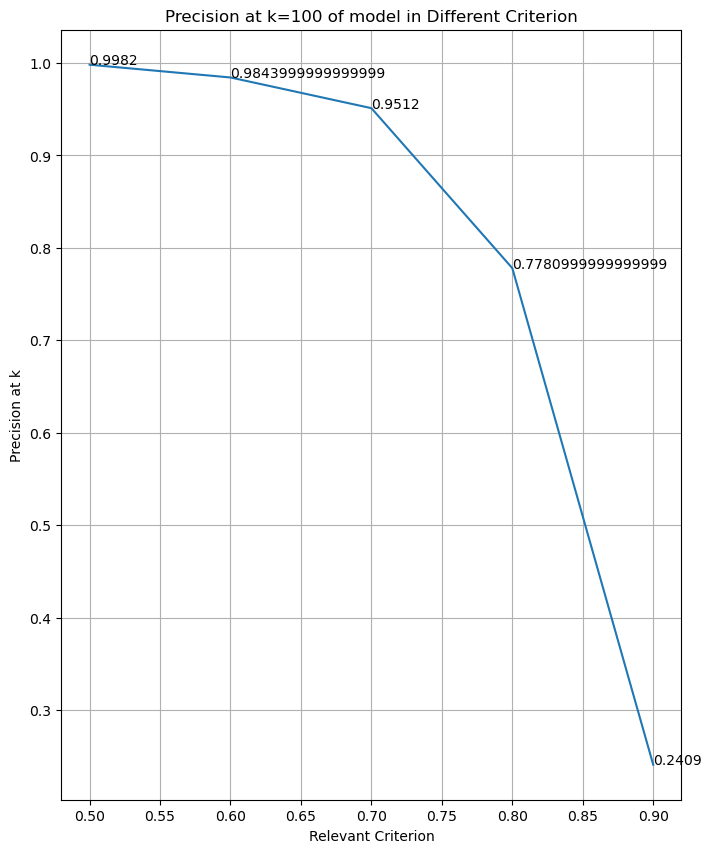

In [58]:
x = np.array(relevant_score)
y = np.array(final_p)
fig = pyplot.figure()
ax = fig.add_subplot(111)
plt.plot(relevant_score, final_p)
plt.ylabel('Precision at k')
plt.xlabel('Relevant Criterion')
plt.title('Precision at k=100 of model in Different Criterion')
for i,j in zip(x,y):
    ax.annotate(str(j),xy=(i,j))
plt.grid(True)
plt.show()

In [59]:
"""In different k criterion """
different_k = [10, 50, 75, 100]
k1 = 82783
relevant_count_final = []
final_list = []
for m in different_k:
    res_v = list(all1_v.keys())
    thislist = []
    relevant_count_list = []
    for j in range(len(res_v[0:100])):

        input = all1_v[res_v[j]]
        xq = model.encode([input])
        D, I = index.search(xq, k1)
    #     res = list(all1.keys())

        # Top k of searcching (All True (True_postive and True Negative))
        k = m

        thislist1 = []
        relevant_count = 0
        for i in I[0][0:k]:
    #         sentences = [input, all1[res[i]]]
    #         embeddings = [nlp(sentence).vector for sentence in sentences]
            s = cos_similarity(emb1[j][0], emb2[i][0])
            thislist1.append(s)
            # print(s)

            if (s >= 0.7):
                relevant_count += 1
        relevant_count_list.append(relevant_count)
        thislist.append(thislist1)
    relevant_count_final.append(relevant_count_list)
    final_list.append(thislist)

In [62]:
ave_relevant_count_final = []
for i in range(len(relevant_count_final)):
    average = Average(relevant_count_final[i])
    ave_relevant_count_final.append(average)

In [64]:
print(ave_relevant_count_final)

[9.58, 47.78, 71.43, 95.12]


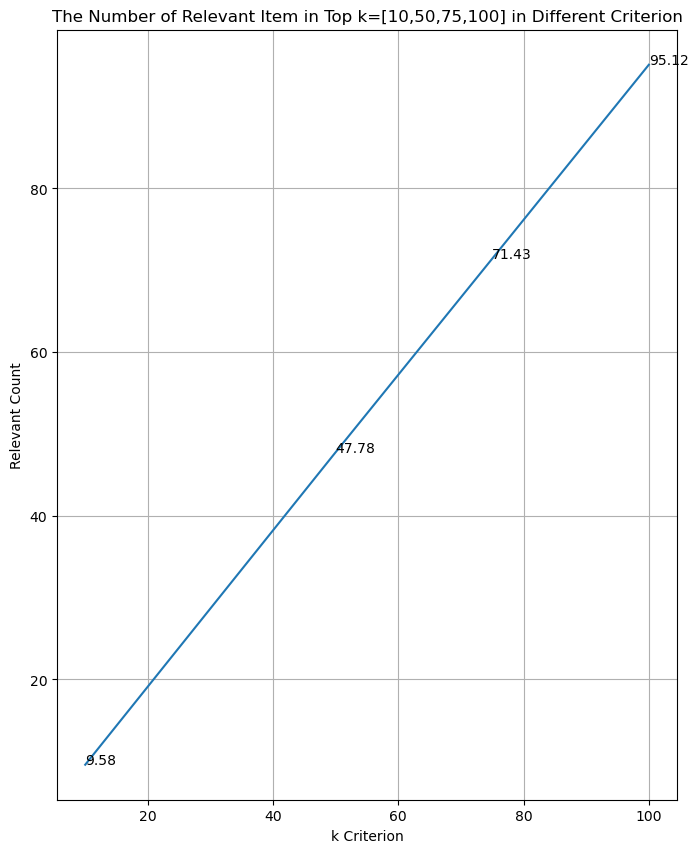

In [65]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
x = np.array(different_k)
y = np.array(ave_relevant_count_final)


fig = pyplot.figure()
ax = fig.add_subplot(111)
plt.plot(different_k, ave_relevant_count_final)
plt.ylabel('Relevant Count')
plt.xlabel('k Criterion')
plt.title('The Number of Relevant Item in Top k=[10,50,75,100] in Different Criterion')
for i,j in zip(x,y):
    ax.annotate(str(j),xy=(i,j))
plt.grid(True)
plt.show()

In [68]:
# Precision at k: relevent item / k
final_p = []
for i in range(len(different_k)):
    precision_k_list = []
    for j in range(len(relevant_count_list)):
        precision_k = relevant_count_final[i][j]/different_k[i]
        precision_k_list.append(precision_k)
        # print("Precision at k: " + str(precision_k))
    final_p.append(Average(precision_k_list))

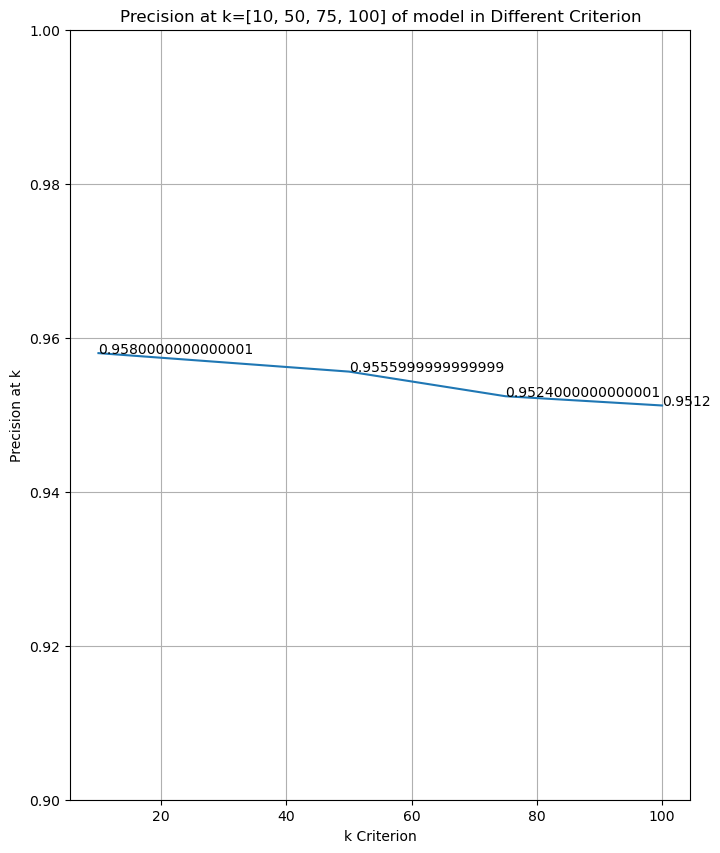

In [72]:
y = np.array(final_p)
fig = pyplot.figure()
ax = fig.add_subplot(111)
plt.plot(different_k, final_p)
ax.set_ylim(.9,1)
plt.ylabel('Precision at k')
plt.xlabel('k Criterion')
plt.title('Precision at k=[10, 50, 75, 100] of model in Different Criterion')
for i,j in zip(x,y):
    ax.annotate(str(j),xy=(i,j))
plt.grid(True)
plt.show()